In [1]:
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

## Figure 2: Protein G Fraction of Native Contacts (Q) CV PMF with Committor

In [2]:
def b_before_a(label_trajectory, state_a=0, state_b=1):
    # save the committor labels
    import numpy as np
    locations_a = np.where(label_trajectory==state_a)[0]
    locations_b = np.where(label_trajectory==state_b)[0]
    #print(len(locations_a), locations_a[:10:])
    #print(len(locations_b), locations_b[:10:])
    #final_known_state = max(locations_a.max(),locations_b.max())
    #print(final_known_state)
    if len(locations_a) == 0:
        #final_known_state = locations_b.max()
        locations_a= np.array([-1])
    if len(locations_b) == 0:
        #final_known_state = locations_a.max()
        locations_b = np.array([-1])
    #else:
    #    final_known_state = max(locations_a.max(),locations_b.max())
    
    final_known_state = max(locations_a.max(), locations_b.max())

    locations_a_iter = iter(locations_a)
    locations_b_iter = iter(locations_b)

    first_a = next(locations_a_iter)
    first_b = next(locations_b_iter)

    #print(first_a)
    #print(first_b)

    commitor = np.zeros( len(label_trajectory) )
    #c = 0
    current_index = 0
    while first_a > -1 and first_b > -1:
        #c += 1
        if first_b < first_a: 
            commitor[current_index:first_b+1] = 1
            current_index = first_b
            first_b = next(locations_b_iter, -1)
        else:
            current_index = first_a + 1
            first_a = next(locations_a_iter, -2)
        #if c<200:
        #    print("first_a,first_b=", first_a, first_b)

    if first_a < 0:
        commitor[current_index:max(locations_b)+1] = 1

    commitor[final_known_state+1:] = -1

    return commitor

In [3]:
unfolded_img = image.imread("unfolded.png")
unfolded_zoom = OffsetImage(unfolded_img,zoom=0.08)
folded_img = image.imread("folded.png")
folded_zoom = OffsetImage(folded_img,zoom=0.07)

In [4]:
traj = np.loadtxt('../../Data/unbiased_cvs.colvar',skiprows=1,usecols=1)
labels = (traj<0.85).astype(int) + (np.logical_and(traj<0.85,traj>0.25)).astype(int)
comm = b_before_a(labels,state_a=0,state_b=1)
#comm = np.loadtxt('../first_pass/comm.dat',skiprows=1)

sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper', rc={'axes.labelsize': 6, 'axes.linewidth': 0.7, 'lines.linewidth': 1.0, 'axes.titlesize': 8,
                             'xtick.labelsize': 6, 'ytick.labelsize': 6, 'xtick.major.width': 0.7, 'ytick.major.width': 0.7,
                             'legend.fontsize': 4.5, 'legend.framealpha': 0, 'lines.markersize': 3})

hist, bins = np.histogram(traj, bins=80, density=True)
kbt = 1.987e-3 * 312
fe = -kbt*np.log(hist)
grids = (bins[:-1] + bins[1:])/2

dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    q_idx = np.where( (traj>=my_bin) * (traj<my_bin+dx) )[0]
    comm_average_var.append([comm[q_idx].mean(),comm[q_idx].var()])
comm_average_var = np.array(comm_average_var)
#print(np.array([list(bins),list(comm_average_var[:,0])]).T)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
#print(points)

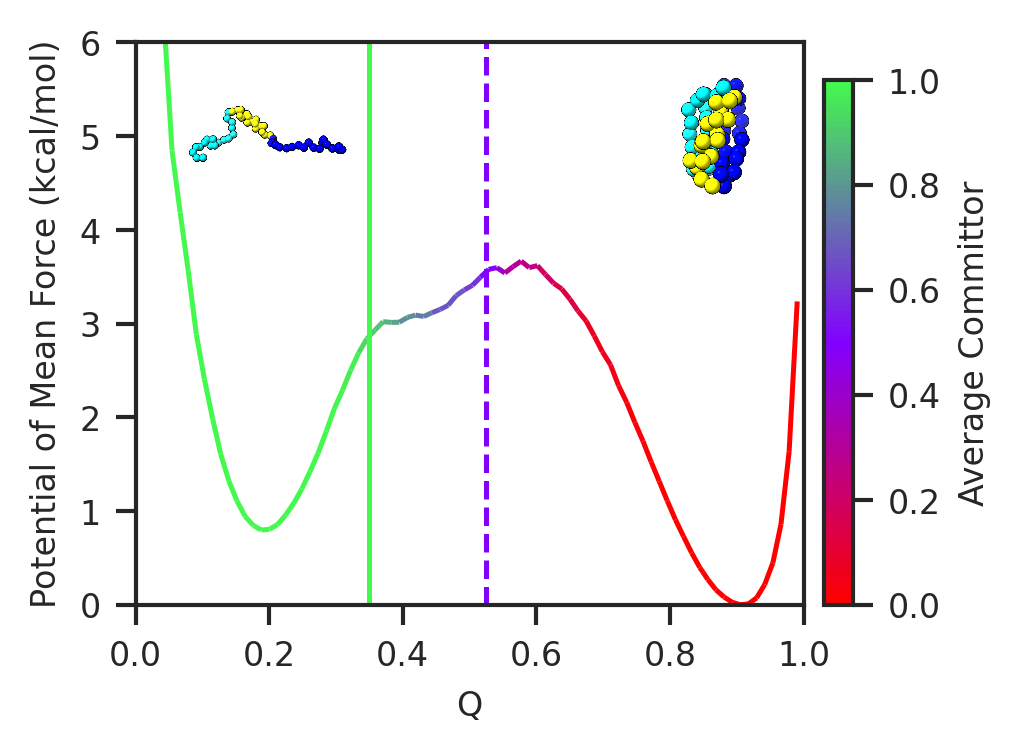

In [5]:
sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper', rc={'axes.labelsize': 8, 'axes.linewidth': 1.0, 'lines.linewidth': 1.2, 'axes.titlesize': 12,
                             'xtick.labelsize': 8, 'ytick.labelsize': 8, 'xtick.major.width': 1.0, 'ytick.major.width': 1.0,
                             'legend.fontsize': 6, 'legend.framealpha': 0, 'lines.markersize': 4})

# Create a continuous norm to map from data points to colors
#norm1 = plt.Normalize(comm_average_var[:,0].min(), comm_average_var[:,0].max())
colors = ['#FF0000','#8200FF','#43F94D']
cmap_name = 'rml'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
norm1 = plt.Normalize(0.0, 1.0)  # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm1)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
#lc.set_linewidth(1)

fig, ax = plt.subplots(figsize=(3.3,2.5),dpi=300)
fig.subplots_adjust(bottom=0.15, top=0.90, right=0.8)

ax.set_xlabel('Q')
ax.set_ylabel('Potential of Mean Force (kcal/mol)')
ax.set_ylim([0,6])
ax.set_xlim([0,1])
line = ax.add_collection(lc)
ax.axline((0.525,0),(0.525,6),linestyle='--',color='#8200FF')
ax.axline((0.35,0),(0.35,6),color='#43F94D')
unfolded_icon = AnnotationBbox(unfolded_zoom, (0.2,5), frameon=False)
ax.add_artist(unfolded_icon)
unfolded_icon = AnnotationBbox(folded_zoom, (0.87,5), frameon=False)
ax.add_artist(unfolded_icon)
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
cbar = plt.colorbar(line, cax=cbar_ax)
cbar.set_label('Average Committor')
pos = cbar.ax.get_position()
pos.x0 = pos.x0 - 0.1
pos.x1 = pos.x1 - 0.1
cbar.ax.set_position(pos)

plt.savefig("EATR_Fig2.pdf",format='pdf')

## Figure S3: PMFs Along Protein G CVs

In [6]:
pmf_r = np.loadtxt('../PMF/pmf_R.dat',skiprows=1)
pmf_q = np.loadtxt('../PMF/pmf_Q.dat',skiprows=1)
pmf_l = np.loadtxt('../PMF/pmf_L.dat',skiprows=1)
pmf_g = np.loadtxt('../PMF/pmf_G.dat',skiprows=1)
pmf_e = np.loadtxt('../PMF/pmf_E.dat',skiprows=1)

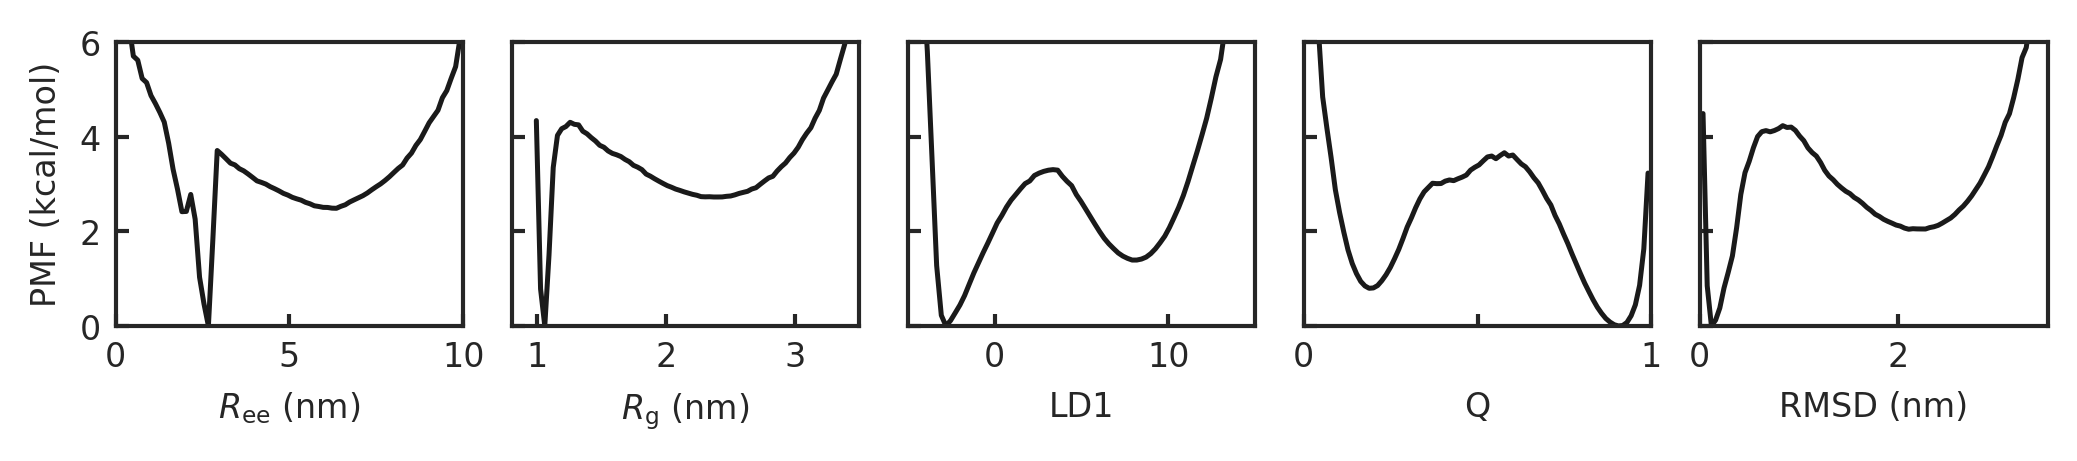

In [7]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(7.,1.5), dpi=300, sharey=True)
fig.subplots_adjust(wspace=(10./72.),bottom=0.25,left=0.05,right=0.97)

ax4.set_xlabel('Q')
ax1.set_ylabel('PMF (kcal/mol)')
ax4.set_ylim([0,6])
ax4.set_xlim([0,1])
ax4.set_xticks([0,0.5,1],labels=['0','','1'])
ax4.plot(pmf_q[:,0],(pmf_q[:,1]-np.min(pmf_q[1:,1]))/4.184,color='k')
ax5.set_xlabel('RMSD (nm)')
ax5.set_xlim([0,3.5])
ax5.plot(pmf_r[:,0],(pmf_r[:,1]-np.min(pmf_r[:,1]))/4.184,color='k')
ax3.set_xlabel('LD1')
ax3.set_xlim([-5,15])
ax3.plot(pmf_l[:,0],(pmf_l[:,1]-np.min(pmf_l[:,1]))/4.184,color='k')
ax2.set_xlabel('$R_{\mathrm{g}}$ (nm)')
ax2.set_xlim([0.8,3.5])
ax2.plot(pmf_g[:,0],(pmf_g[:,1]-np.min(pmf_g[:,1]))/4.184,color='k')
ax1.set_xlabel('$R_{\mathrm{ee}}$ (nm)')
ax1.set_xlim([0,10])
ax1.plot(pmf_e[:,0],(pmf_e[:,1]-np.min(pmf_e[:,1]))/4.184,color='k')

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.tick_params(axis='both', direction='in', which='both', length=3)

plt.savefig("EATR_FigS3.pdf",format='pdf')